<font size=6> <b> 6 주차 강의 Notebook </b> </font>
<div class="alert alert-block alert-success">
  주식 정보를 읽어서 분석하고, 투자 알고리즘의 성능 분석하는 법을 확인해 보자! <br>
    
   <b> Note </b> : 새로운 주제를 다루면서 Pandas의 활용법도 함께 확인!! <br>
</div>
</div>

<p style="text-align:right;"> sumyeon@gmail.com </p>


<hr>

- 필요한 패키지 인스톨

> pip install pandas_datareader

<hr>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import datetime
import pandas_datareader.data as pdrdata

%matplotlib inline
!chcp 949

Active code page: 65001
활성 코드 페이지: 949


# 증권 투자 기본 정보 준비

## 한국 증권 거래소에서 상장회사 정보를 다운받아 준비
 - http://marketdata.krx.co.kr/mdi#document=040601

In [2]:
metadf = pd.read_csv("krxstockdata.csv", dtype={"종목코드":str})

In [3]:
metadf.head()

,번호,종목코드,기업명,업종코드,업종,상장주식수(주),자본금(원),액면가(원),통화구분,대표전화,주소,총카운트
0,1,060310,3S,32902,특수 목적용 기계 제조업,"44,802,511","22,401,255,500",500,원(KRW),02-896-9474,서울특별시 금천구 시흥대로71길 30-1,2367
1,2,095570,AJ네트웍스,147603,산업용 기계 및 장비 임대업,"46,822,295","46,822,295,000","1,000",원(KRW),02-6363-9999,"서울특별시 송파구 정의로8길 9 (문정동,AJ빌딩)",2367
2,3,006840,AK홀딩스,116409,기타 금융업,"13,247,561","66,237,805,000","5,000",원(KRW),02-768-2923,서울특별시 마포구 양화로 188 -,2367
3,4,054620,APS홀딩스,116409,기타 금융업,"20,394,221","10,197,110,500",500,원(KRW),031-776-1800,경기도 화성시 동탄면 동탄산단9길 23-12 (동탄면),2367
4,5,265520,AP시스템,32902,특수 목적용 기계 제조업,"14,480,227","7,240,113,500",500,원(KRW),031-379-2700,경기도 화성시 동탄면 동탄산단8길 15-5 &nbsp,2367


<div class="alert alert-block alert-info">
<b> Tip:</b> https://wendys.tistory.com/173 에서와 같이 파일 다운로드를 건너뛰고 바로 데이터를 읽어들이는 방법도 가능 </b> <br> <br>
<pre>
metadf = pd.read_html('http://kind.krx.co.kr/corpgeneral/corpList.do?method=download&searchType=13', header=0)[0]
</pre>
</div>

## ETF 형태의 증권 정보를 추가로 확보 (optional)

In [4]:
meta2df = pd.read_csv("etfitemdata.csv", sep="\t")

In [5]:
meta2df.head(2)

,대분류,중분료,업종명,종목명,종목코드
0,주식(ETF),유가,KOSPI,KODEX 200,'069500
1,주식(ETF),유가,KOSPI,TIGER 200,'102110


In [6]:
meta2df['종목코드'] = meta2df['종목코드'].map(lambda x : x[1:])

In [7]:
meta2df.head(2)

,대분류,중분료,업종명,종목명,종목코드
0,주식(ETF),유가,KOSPI,KODEX 200,069500
1,주식(ETF),유가,KOSPI,TIGER 200,102110


In [8]:
set(metadf['종목코드'].values) & set(meta2df['종목코드'].values)

set()

## 회사명 <--> 종목코드간 변환 위한 dictionary 준비

In [9]:
name2code_dict = dict(zip( metadf['기업명'].values, metadf['종목코드'].values))
code2name_dict = dict(zip( metadf['종목코드'].values, metadf['기업명'].values))

In [10]:
name2code_dict.update(dict(zip( meta2df['종목명'].values, meta2df['종목코드'].values)) )
code2name_dict.update(dict(zip( meta2df['종목코드'].values, meta2df['종목명'].values)))

In [11]:
name2code_dict['KODEX 200'], name2code_dict['삼성전자'], code2name_dict['005930']

('069500', '005930', '삼성전자')

# pandas_datareader 설명 <br>

- https://pandas-datareader.readthedocs.io/en/latest/remote_data.html

- 원격의 데이터를 pandas로 쉽게 읽어 들이기 위한 패키지. 
다양한 데이터를 목표로 하였으나, 전체 16개 정도의 데이터 소스 중에서 OECD 통계 (https://stats.oecd.org/), Eurostat (https://ec.europa.eu/eurostat/) , Enigma (https://enigma.com/) 정도를 제외한 나머지는 주식 정보와 같은 financial 데이터임

- Naver 증권 데이터가 pandas_datareader에서 지원됨. Yahoo Finace도 한국 증권정보를 지원하나, 안정성을 위해
Naver를 사용키로 함

- 기업 경영 상태에 대한 정보는 다트 (http://dart.fss.or.kr/)를 통해서 알아보자. <br>
다트는 기업정보 전자공시 사이트로서 기업의 경영 상태에 대한 상세한 정보를 구할 수 있다. <br>
(참고로, 미국과 유럽에는 없고 한국에만 있는 시스템이라 워렌 버핏이  극찬한 시스템이라고 함)

# Utility Function을 만들어 보자

- 관심 있는 기업의 주가 정보, 회사 이름으로 가져오는 기능을 구축해 보자!

## pandas_datareader 사용법

In [12]:
pdrdata.DataReader('054620', 'naver', '2020-08-01','2020-08-15')

,Open,High,Low,Close,Volume
Date,,,,,
2020-08-03,8560,8650,8280,8530,250642
2020-08-04,8550,9050,8310,9000,543993
2020-08-05,9040,9110,8820,9000,250344
2020-08-06,8960,9000,8650,8800,253172
2020-08-07,8800,8880,8640,8690,217212
2020-08-10,8790,9100,8650,8830,406855
2020-08-11,8880,9130,8850,9130,577527
2020-08-12,9230,9550,8920,9530,872553
2020-08-13,9530,10950,9530,10000,1499683


## 회사별 주식 정보를 리턴

In [13]:
def getStockHistory(companylist, start='2018-01-01', end=datetime.datetime.now().strftime('%Y-%m-%d')):
    """
    return the stock histories of the companies given
    
    Parameters:
        companylist : list - list of company names or codes 
        start       : Str - start date string
        end         : Str - end date string
        
    Returns:
        list : list of stock history data frame
    """
    
    if isinstance(companylist[0], str) and not companylist[0].isnumeric():
        companylist = [name2code_dict[name] for name in companylist]
    
    dflist = [pdrdata.DataReader(code, 'naver', start, end) for code in companylist]
    dflist2 = [df.apply(pd.to_numeric) for df in dflist]
    
    for idx, code in enumerate(companylist):
        dflist2[idx]['name'] = code2name_dict[code]      # index에 회사명을 추가
        dflist2[idx] = dflist2[idx].set_index('name', append=True).unstack()   # index의 회사명을 column으로 보내기
        dflist2[idx] = dflist2[idx].swaplevel(0,1,1)
    return pd.concat(dflist2, axis=1)

In [14]:
getStockHistory(["삼성전자","LG화학"], start='2010-08-01').head(5)

name         삼성전자                                 LG화학                  \
             Open   High    Low  Close  Volume    Open    High     Low   
Date                                                                     
2010-08-02  16340  16360  16200  16200  249388  334000  343000  332000   
2010-08-03  16400  16440  16300  16300  262302  340000  343000  334500   
2010-08-04  16340  16360  16120  16120  213434  343500  344000  337000   
2010-08-05  16220  16360  16060  16080  280897  340000  341500  324000   
2010-08-06  16200  16200  15979  16020  247165  324500  329500  315500   

name                        
             Close  Volume  
Date                        
2010-08-02  343000  303805  
2010-08-03  343000  359051  
2010-08-04  339000  231541  
2010-08-05  330500  403689  
2010-08-06  327000  375963

<div class="alert alert-block alert-info">
<b> Tip:</b> Open(시가), High (최고가), Low (최저가), Close (종가), Volumne(거래량) </b> <br>
</div>

## 업종별 회사 리스트 

In [15]:
def get_cclist_by_subject(subject):
    cclist = metadf[metadf['업종'] == subject]['종목코드'].values
    if len(cclist) == 0:
        raise ValueError("없는 업종")
        
    return cclist

In [16]:
get_cclist_by_subject('의료용품 및 기타 의약 관련제품 제조업')

array(['138610', '142280', '343090', '233250', '059210', '206640',
       '064550', '100700', '253840', '096530', '246720', '260660',
       '174900', '950130', '153710', '278380', '246960', '086890',
       '216080', '229000', '228760', '046210', '303360', '241820',
       '042520', '205470'], dtype=object)

In [17]:
getStockHistory(get_cclist_by_subject('의료용품 및 기타 의약 관련제품 제조업'),'2020-08-20','2020-08-24')

name          나이벡                              녹십자엠에스                       \
             Open   High    Low  Close  Volume   Open   High    Low  Close   
Date                                                                         
2020-08-21  21700  22800  20200  20750  493272  11250  11300  10550  10600   
2020-08-24  20600  20600  18600  20200  254572  11400  11400  10750  11100   

name                ... 한스바이오메드                                휴마시스         \
            Volume  ...    Open   High    Low  Close  Volume   Open   High   
Date                ...                                                      
2020-08-21  565411  ...   18400  19800  17500  19750  146136  15100  15100   
2020-08-24  939253  ...   19600  19600  18900  19300   62982  13800  14500   

name                               
              Low  Close   Volume  
Date                               
2020-08-21  14050  14050  4284923  
2020-08-24  13700  14000  2018302  

[2 rows x 130 columns]

# 주식 챠트를 그려보자

## 한글 폰트 등록

In [18]:
import matplotlib.font_manager as fm
font_name = fm.FontProperties(fname='C:\\WINDOWS\\Fonts\\HYWULM.TTF').get_name()
plt.rc('font', family=font_name)

## 회사 챠트 그려보기 

In [19]:
name = "씨젠"

In [20]:
stockdf = getStockHistory([name], start='2019-01-01')

In [21]:
stockdf.head()

name           씨젠                             
             Open   High    Low  Close  Volume
Date                                          
2019-01-02  16200  16300  15500  15600  107409
2019-01-03  15600  15700  14700  14750  188496
2019-01-04  14500  15200  14450  15000  177514
2019-01-07  15200  15400  14950  15200  132940
2019-01-08  15400  16150  15150  15600  200127

<AxesSubplot:xlabel='Date'>

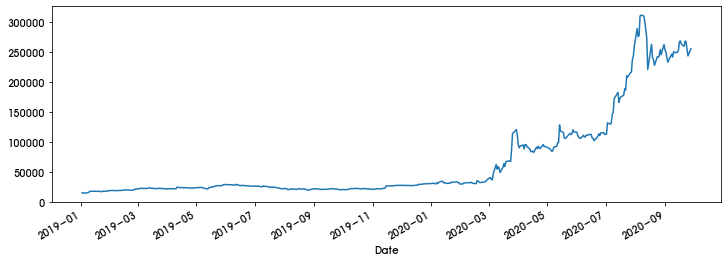

In [22]:
stockdf[(name,'Close')].plot(figsize=(12,4))

## 회사 챠트 만들기 - 자유롭게 회사 선택

 - ipywidget을 활용해서 interactive하게 종목과 날짜를 바꾸어 볼 수 있는 그래프 그리기
 > widgets은 ipython(jupyter)에 interactive한 요소를 추가 해주는 기능

In [23]:
import ipywidgets as widgets

> <b> 실제 그래프를 표시할 함수 만들기 </b> <br>
> widget에서 리턴되는 내용들이 argument가 되어, 수행하는 함수 만들기. widget값이 바뀔 경우 함수가 자동 재수행됨

In [24]:
def draw_chart(name_list, date_range, values):
    """
    
    """
    fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(16,6))
    stockdf = getStockHistory([name_list], date_range[0].strftime("%Y-%m-%d"), date_range[1].strftime("%Y-%m-%d"))
    stockdf = stockdf.droplevel(0, axis=1)
    stockdf[list(values)].plot(ax=ax)
    #plt.scatter(stockdf.index, targetdf['Close'], color='Black')

> <b> 표시 기간/날짜를 선택하는 widget 만들기 </b> <br>
> 먼저, 전체 기간의 시작과 끝을 정하고, 해당 기간을 선택할 option으로 만들어 제공하면 선택 결과가 tuple로 return됨

In [25]:
start_date = datetime.datetime(2019, 1, 1)
end_date = datetime.datetime.now().date()
dates = pd.date_range(start_date, end_date, freq='D')

options = [(date.strftime(' %Y-%m-%d '), date) for date in dates]
index = (0, len(options)-1)

selection_range_slider = widgets.SelectionRangeSlider(
    options=options,
    index=index,
    description='Dates',
    orientation='horizontal',
    layout={'width': '500px'}
)

> <b> 표시할 내용 선택 widget 만들기 </b> <br>
> 여러 값들 중에서 선택한 내용이 리스트로 전달됨. 주의) 복수 선택 가능

In [26]:
selection_values = widgets.SelectMultiple(
    options=['Open','Close','High','Low'],
    value=['Close'],
    description='Values',
    disabled=False
)

> <b> widgets.ineract를 통해 interactive한 함수 기능 제공 </b> <br>
> 준비해둔 widget과 함수를 연결해주는 내용

In [27]:
widgets.interact(draw_chart, name_list = name2code_dict.keys(), date_range=selection_range_slider, values=selection_values)

interactive(children=(Dropdown(description='name_list', options=('3S', 'AJ네트웍스', 'AK홀딩스', 'APS홀딩스', 'AP시스템', '…

<function __main__.draw_chart(name_list, date_range, values)>

<div class="alert alert-block alert-info">
<b> Tip:</b> draw_chart 함수를 개선해서, 거래량을 추가하거나 또는 두 개 이상의 회사 챠트를 그리는 것 도 가능 </b> <br>
=> 나만의 주가 대시보드를 만들어보는 프로젝트도 가능!!
</div>

<hr>

# 주가 투자 알고리즘의 성능 평가

## 주가 투자 알고리즘 template 정의 

- Close (종가) 기준으로 매수/매도 날짜를 추천 

- 추천된 매수/매도 날짜 list를 가지고 투자의 결과를 평가

## 주가 투자 알고리즘 성능 평가 함수 만들기

 - 알고리즘의 결과물로 나오는 (매수일자,매도일자) 리스트를 받아, 투자를 지속한 결과를 보여줌
 - 최종 출력은 (최종 보유 금액) / (첫 보유 금액) 에 대한 %를 출력

In [28]:
def measure_gains(tdf, invest_list, total_money=5_000_000, commision_perc=5):
    
    invest_money = total_money
    tdf= tdf.resample('D').fillna('ffill')
    tdf = tdf.droplevel(0, axis=1)
    for [sdate,edate] in invest_list:
        sdate_price = tdf.loc[sdate, 'Close']
        stock_amount = invest_money // sdate_price
        remain_money = invest_money - stock_amount * sdate_price
        edate_price = tdf.loc[edate, 'Close']
        invest_money = stock_amount * edate_price * (100-commision_perc)/100 + remain_money
        
    return invest_money / total_money * 100

# 레퍼런스 투자 알고리즘을 만들어 보자
> 미래의 주가 등락을 미리 알고 있어 매우 정확한 투자를 할 수 있는 알고리즘을 레퍼런스(비교) 알고리즘으로 상정 <br>
> 세부 로직 : 3일 이상 계속 상승이 예상되면 매수, 가격 하락이 시작되기 직전 매도 <br>
> suboptimal : 미래의 급등락을 정확하게 맞출 수 있으므로 비교 가능한 상황에서는 거의 최고 성능의 알고리즘

 - 한 회사의 주식 정보를 가지고 레퍼런스 알고리즘을 만들어 보자 <br>
 

In [29]:
name = "삼성전자"
stockdf = getStockHistory([name], start='2019-01-01')

 - 주식 정보는 토/일이 missing되어 있으므로, time-series 분석을 위해 토/일요일 정보를 forward fill 방식으로 채우자

In [30]:
stockdf[:10]

name         삼성전자                               
             Open   High    Low  Close    Volume
Date                                            
2019-01-02  39400  39400  38550  38750   7847664
2019-01-03  38300  38550  37450  37600  12471493
2019-01-04  37450  37600  36850  37450  14108958
2019-01-07  38000  38900  37800  38750  12748997
2019-01-08  38000  39200  37950  38100  12756554
2019-01-09  38650  39600  38300  39600  17452708
2019-01-10  40000  40150  39600  39800  14731699
2019-01-11  40350  40550  39950  40500  11661063
2019-01-14  40450  40700  39850  40050  11984996
2019-01-15  40050  41100  39850  41100  11492756

In [31]:
stockdf= stockdf.resample('D').fillna('ffill')

In [32]:
stockdf[:10]

name         삼성전자                               
             Open   High    Low  Close    Volume
Date                                            
2019-01-02  39400  39400  38550  38750   7847664
2019-01-03  38300  38550  37450  37600  12471493
2019-01-04  37450  37600  36850  37450  14108958
2019-01-05  37450  37600  36850  37450  14108958
2019-01-06  37450  37600  36850  37450  14108958
2019-01-07  38000  38900  37800  38750  12748997
2019-01-08  38000  39200  37950  38100  12756554
2019-01-09  38650  39600  38300  39600  17452708
2019-01-10  40000  40150  39600  39800  14731699
2019-01-11  40350  40550  39950  40500  11661063

 - 종가 기준으로 어제의 종가와 비교해서 증감 내역과 그 ratio를 계산해 두자

In [33]:
tdf =stockdf[name]   # 또는 tdf = stockdf.droplevel(0,axis=1)

In [35]:
tdf['tomorrow_delta'] = tdf['Close'].shift(-1) - tdf['Close']   # 내일의 주가를 가져와 오늘의 주가와 차이름 추출

tdf['tomorrow_ratio'] = tdf['tomorrow_delta'] / tdf['Close'] * 100 # 오늘의 주가 대비, 내일의 주가를 확인

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [36]:
tdf = tdf[['Close','tomorrow_delta']]

In [37]:
tdf.head()

,Close,tomorrow_delta
Date,,
2019-01-02,38750,-1150.0
2019-01-03,37600,-150.0
2019-01-04,37450,0.0
2019-01-05,37450,0.0
2019-01-06,37450,1300.0


<div class="alert alert-block alert-info">
<b> Tip:</b> Pandas의 pct_change 함수를 이용해서 한번에 증감 정보를 계산하는 것도 가능! <br> <br>
<pre>
tdf['pct_change'] = tdf['Close'].pct_change().shift(-1)
</pre>
</div>

 - 핵심 알고리즘 구현 : 3일 이상 계속 상승하면 매수! 가격이 꺽이는 날 직전에 매도!!

In [38]:
invest_list = []
during_invest = False

# 주가를 하루 하루 날짜별로 쫒아 가보자
for rows in tdf.itertuples():
    if rows[2] < 0 and during_invest:               # row[0] => 날짜 (index) , row[2] => 증감정보
        invest.append(rows[0])  # set today as end date of invest
        during_invest = False
        if (invest[1] - invest[0]).days >= 3:
            invest_list.append(invest)
    elif rows[2] < 0 and not during_invest:
        continue
    elif rows[2] > 0 and during_invest:
        continue
    elif rows[2] > 0 and not during_invest:
        invest = [rows[0]]
        during_invest = True

invest_list

[[Timestamp('2019-01-08 00:00:00', freq='D'),
  Timestamp('2019-01-13 00:00:00', freq='D')],
 [Timestamp('2019-01-14 00:00:00', freq='D'),
  Timestamp('2019-01-21 00:00:00', freq='D')],
 [Timestamp('2019-01-23 00:00:00', freq='D'),
  Timestamp('2019-01-30 00:00:00', freq='D')],
 [Timestamp('2019-01-31 00:00:00', freq='D'),
  Timestamp('2019-02-06 00:00:00', freq='D')],
 [Timestamp('2019-02-10 00:00:00', freq='D'),
  Timestamp('2019-02-14 00:00:00', freq='D')],
 [Timestamp('2019-02-19 00:00:00', freq='D'),
  Timestamp('2019-02-25 00:00:00', freq='D')],
 [Timestamp('2019-03-14 00:00:00', freq='D'),
  Timestamp('2019-03-17 00:00:00', freq='D')],
 [Timestamp('2019-03-18 00:00:00', freq='D'),
  Timestamp('2019-03-24 00:00:00', freq='D')],
 [Timestamp('2019-03-31 00:00:00', freq='D'),
  Timestamp('2019-04-04 00:00:00', freq='D')],
 [Timestamp('2019-04-11 00:00:00', freq='D'),
  Timestamp('2019-04-16 00:00:00', freq='D')],
 [Timestamp('2019-04-25 00:00:00', freq='D'),
  Timestamp('2019-04-29 

## 비교 (레퍼런스) 알고리즘 end-to-end 모듈화 (함수화)

In [39]:
def realistic_optimal(targetdf, min_investdays=3):
    
    targetdf= targetdf.resample('D').fillna('ffill')
    tdf = targetdf.droplevel(0, axis=1)
    tdf = tdf[['Close']]
    tdf['tomorrow_gap'] = tdf['Close'].shift(-1) - tdf['Close'] 
    tdf['tomorrow_ratio'] = tdf['tomorrow_gap'] / tdf['Close'] * 100
    
    invest_list = []
    during_invest = False
    for rows in tdf.itertuples():
        if rows[2] < 0 and during_invest:
            invest.append(rows[0])  # set today as end date of invest
            during_invest = False
            if (invest[1] - invest[0]).days >= min_investdays:
                invest_list.append(invest)
        elif rows[2] < 0 and not during_invest:
            continue
        elif rows[2] > 0 and during_invest:
            continue
        elif rows[2] > 0 and not during_invest:
            invest = [rows[0]]
            during_invest = True
            
    return invest_list

In [40]:
realistic_optimal(stockdf)

[[Timestamp('2019-01-08 00:00:00', freq='D'),
  Timestamp('2019-01-13 00:00:00', freq='D')],
 [Timestamp('2019-01-14 00:00:00', freq='D'),
  Timestamp('2019-01-21 00:00:00', freq='D')],
 [Timestamp('2019-01-23 00:00:00', freq='D'),
  Timestamp('2019-01-30 00:00:00', freq='D')],
 [Timestamp('2019-01-31 00:00:00', freq='D'),
  Timestamp('2019-02-06 00:00:00', freq='D')],
 [Timestamp('2019-02-10 00:00:00', freq='D'),
  Timestamp('2019-02-14 00:00:00', freq='D')],
 [Timestamp('2019-02-19 00:00:00', freq='D'),
  Timestamp('2019-02-25 00:00:00', freq='D')],
 [Timestamp('2019-03-14 00:00:00', freq='D'),
  Timestamp('2019-03-17 00:00:00', freq='D')],
 [Timestamp('2019-03-18 00:00:00', freq='D'),
  Timestamp('2019-03-24 00:00:00', freq='D')],
 [Timestamp('2019-03-31 00:00:00', freq='D'),
  Timestamp('2019-04-04 00:00:00', freq='D')],
 [Timestamp('2019-04-11 00:00:00', freq='D'),
  Timestamp('2019-04-16 00:00:00', freq='D')],
 [Timestamp('2019-04-25 00:00:00', freq='D'),
  Timestamp('2019-04-29 

## 비교 알고리즘을 평가해 보자!

In [41]:
invest_list = realistic_optimal(stockdf)

In [42]:
earn_ratio = measure_gains(stockdf, invest_list)

In [43]:
print(f"The earn ratio is {earn_ratio:.0f}% !!")

The earn ratio is 67% !!


# 알고리즘 Visualization
> 전체 챠트에서, 투자 기간 (매수/매도) 기간을 표시

In [44]:
import matplotlib
matplotlib.style.use('ggplot')

In [45]:
def visualize_invest(targetdf, invest_list):
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,6))
    
    # draw whole graph
    targetdf= targetdf.resample('D').fillna('ffill')
    tdf = targetdf.droplevel(0,1)
    tdf = tdf[['Close']]
    tdf['Close'].plot(ax=ax, color='yellow', linewidth=3)
    
    #plt.scatter(targetdf.index, targetdf['Close'], color='Black')
    
    
    #draw invest graph
    for [sdate,edate] in invest_list:
        tdf.loc[sdate:edate,'Close'].plot(ax=ax, color='red', linewidth=2)

        

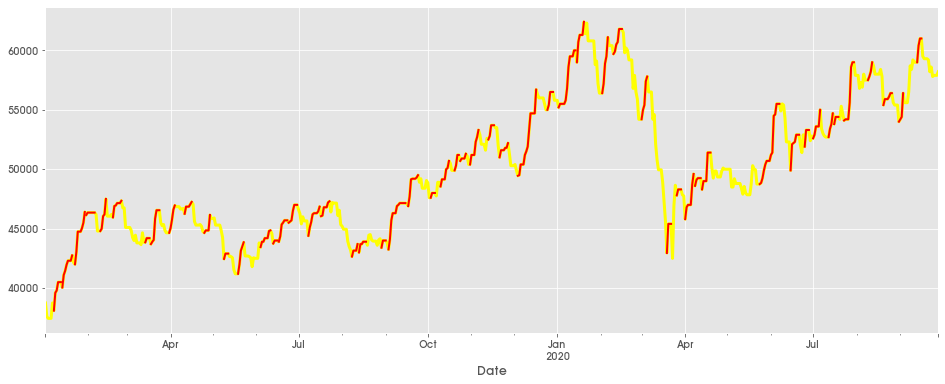

In [46]:
visualize_invest(stockdf, invest_list)

<div class="alert alert-block alert-info">
<b> Tip:</b> 노란색이 주가 변화를, 빨간색으로 나타난 부분이 매입/매도 구간을 나타냄
</div>